### optuna で得た lr で学習させる、CP使ってモデルを保存する

In [1]:
import os
import re
import datetime
import random
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')


def generate_data(x, t, num=5):
  datagen = ImageDataGenerator(
    #rotation_range=180,     # randomly rotate images in the range
    zoom_range=0.2,         # randomly zoom image
    width_shift_range=0.2,  # randomly shift images horizontally
    height_shift_range=0.2, # randomly shift images vertically
    horizontal_flip=True,   # randomly flip images horizontally
    #vertical_flip=True      # randomly flip images vertically
  )

  x_list = []
  t_list = []

  x_array = np.expand_dims(x, axis=0)

  datagen.fit(x_array)

  iter = datagen.flow(x_array, batch_size=1)

  for i in range(num):
    ret = iter.next()
    #print(ret.shape, ret.dtype)
    x_list.append(ret[0])
    t_list.append(t)

  return x_list, t_list


def prepare_data(gen_num=5):
  x, t = [], []

  categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

  for dir_path in categorized_dir_paths:
    category_id = os.path.basename(dir_path)
    image_paths = glob(os.path.join(dir_path, '*'))
    print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

    for i, p in enumerate(image_paths):
      book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

      if i % 30 == 0:
          print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

      try:
          img = Image.open(p)
          img_resize = img.resize((229, 229))
          img_np = np.array(img_resize) / 255.0

          x.append(img_np)
          t.append(category_id)

          x_gen, t_gen = generate_data(img_np, category_id, gen_num)
          x.extend(x_gen)
          t.extend(t_gen)

      except Exception as e:
          print(datetime.datetime.now().isoformat(), 'Error:', e)

  return x, t


def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

reset_seed(0)


x, t = prepare_data(5)
print(len(x), len(t))

x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)
print(x_train.shape, x_val.shape)

category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2020-06-24T06:22:19.746176 Category 0 : 117
2020-06-24T06:22:19.746883 Image: 0 1015 0
2020-06-24T06:22:21.618759 Image: 30 1228 0
2020-06-24T06:22:23.506856 Image: 60 1106 0
2020-06-24T06:22:25.345396 Image: 90 1129 0
2020-06-24T06:22:26.995968 Category 1 : 119
2020-06-24T06:22:26.996178 Image: 0 3636 1
2020-06-24T06:22:28.824011 Image: 30 3722 1
2020-06-24T06:22:30.666530 Image: 60 3832 1
2020-06-24T06:22:32.537184 Image: 90 3777 1
2020-06-24T06:22:34.299015 Category 2 : 129
2020-06-24T06:22:34.299511 Image: 0 3601 2
2020-06-24T06:22:36.122380 Image: 30 3884 2
2020-06-24T06:22:37.897866 Image: 60 3778 2
2020-06-24T06:22:39.688410 Image: 90 3853 2
2020-06-24T06:22:41.496865 Image: 120 1502 2
2020-06-24T06:22:42.058572 Category 3 : 111
2020-06-24T06:22:42.059248 Image: 0 3312 3
2020-06-24T06:22:43.856159 Image: 30 2350 3
2020-06-24T06:22:45.667116 Image: 60 3

In [2]:
def create_model():
  model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])
  
  for layer in model_fine.layers[:100]:
      layer.trainable = False
  
  model = models.Sequential()
  model.add(model_fine)
  
  model.add(layers.Flatten())
  
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(category_count, activation='softmax'))
  
  optimizer = keras.optimizers.Adagrad(lr=0.004705)
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint_path = '/content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-{epoch:04d}.ckpt'
checkpoint_path = '/content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt'

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False,
                             period=1,
                             verbose=0)

2020-06-24T06:38:10.546671 Start
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /con

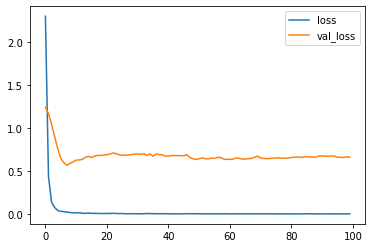

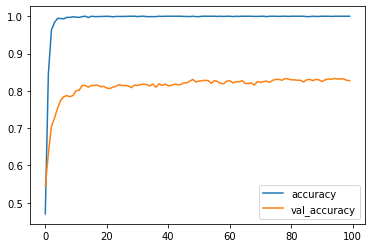

In [4]:
print(datetime.datetime.now().isoformat(), 'Start')

model = create_model()

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=100,
    verbose=0,
    validation_data=(x_val, t_val),
    callbacks=[checkpoint]
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

In [5]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
95,0.001336,1.0,0.661582,0.831972
96,0.000689,1.0,0.661104,0.831972
97,0.000763,1.0,0.658671,0.831972
98,0.000807,1.0,0.665882,0.828471
99,0.000601,1.0,0.663437,0.827305


2020-06-24T07:19:47.256385 Start
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets

,loss,accuracy,val_loss,val_accuracy
495,0.000155,1.0,0.655615,0.857643
496,0.000125,1.0,0.655751,0.855309
497,0.000699,1.0,0.665505,0.854142
498,0.000127,1.0,0.663014,0.854142
499,0.000225,1.0,0.659032,0.854142


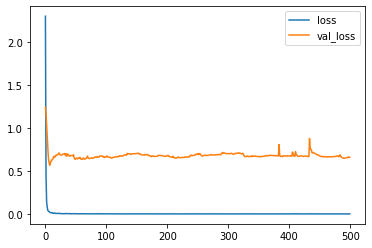

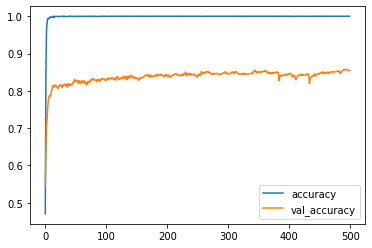

In [6]:
print(datetime.datetime.now().isoformat(), 'Start')

#model = create_model()

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=400,
    verbose=0,
    validation_data=(x_val, t_val),
    callbacks=[checkpoint]
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

results.tail()

In [7]:
history_csv_path = '/content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4_history.csv'

results.to_csv(history_csv_path)

2020-06-24T09:28:54.330900 Start
2020-06-24T12:00:42.904428 End


,loss,accuracy,val_loss,val_accuracy
995,0.000042,1.0,0.737603,0.849475
996,0.000114,1.0,0.734033,0.848308
997,0.000073,1.0,0.734613,0.847141
998,0.000053,1.0,0.733323,0.848308
999,0.000214,1.0,0.731073,0.848308


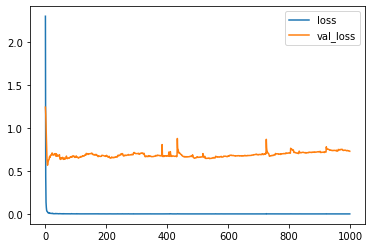

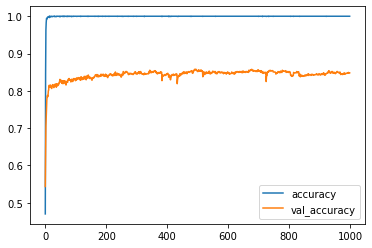

In [8]:
print(datetime.datetime.now().isoformat(), 'Start')

#model = create_model()

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=500,
    verbose=0,
    validation_data=(x_val, t_val),
    callbacks=[checkpoint]
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

results.to_csv(history_csv_path)

results.tail()

In [9]:
results['val_accuracy'].max()

0.8576429486274719

In [ ]:
print(datetime.datetime.now().isoformat(), 'Start')

#model = create_model()

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=500,
    verbose=0,
    validation_data=(x_val, t_val),
    callbacks=[checkpoint]
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

results.to_csv(history_csv_path)

print(results['val_accuracy'].max())

results.tail()

2020-06-24T12:02:22.304333 Start
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt/assets
